# Admixture in 2L

## Input

Input files:

In [1]:
# output
outdir   = "admixture_analysis_output_pergenotype"
outcode  = "rdl_admix"

# gene of interest
chrom     = "2L"
loc_start = 25363652 # start gene
loc_end   = 25434556 # end gene

# inversion 2La
inv_start = 20524058 # interval 20524058 - 20528089
inv_end   = 42165532 # interval 42165182 - 42165532

# input data phase2
popc          = "population" 
p2_metasam_fn = "data/samples_p2.meta.txt"
p2_callset_fn = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/haplotypes/zarr2/ag1000g.phase2.ar1.samples/"      #### EDIT THIS 
p2_accessi_fn = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/accessibility/accessibility.h5"                    #### EDIT THIS 
p2_popc       = popc
p2_popl       = ["AOcol","BFcol","BFgam","CIcol","CMgam","FRgam","GAgam","GHcol","GHgam","GM","GNcol","GNgam","GQgam","GW","KE","UGgam"]

# outgroup populations
ou_species    = ["arab","quad","meru","mela","epir","chri"]
ou_callset_fl = ["/home/xavi/dades/Variation/phase1.AR3_Fontaine_AltSps/haplotypes/arab_ref_hc_vqsr_cnvrt_sort.zarr/", #### EDIT THIS 
                 "/home/xavi/dades/Variation/phase1.AR3_Fontaine_AltSps/haplotypes/quad_ref_hc_vqsr_cnvrt_sort.zarr/", #### EDIT THIS 
                 "/home/xavi/dades/Variation/phase1.AR3_Fontaine_AltSps/haplotypes/meru_hc_vqsr_cnvrt_sort.zarr/",     #### EDIT THIS 
                 "/home/xavi/dades/Variation/phase1.AR3_Fontaine_AltSps/haplotypes/mela_ref_hc_vqsr_good_cnvrt_sort.zarr/", #### EDIT THIS 
                 "/home/xavi/dades/Variation/phase1.AR3_Fontaine_AltSps/genotypes/epir_fake_cnvrt_sort.zarr/",         #### EDIT THIS 
                 "/home/xavi/dades/Variation/phase1.AR3_Fontaine_AltSps/genotypes/chri_fake_cnvrt_sort.zarr/"]         #### EDIT THIS 
ou_metasam_fl = ["data/samples.metaara.txt",
                 "data/samples.metaqua.txt",
                 "data/samples.metamer.txt",
                 "data/samples.metamel.txt",
                 "data/samples.metaepi.txt",
                 "data/samples.metachr.txt"]
ou_popc       = popc


# accessibility phase2
accessi_fn = "/home/xavi/Documents/VariationAg1k/data/phase2.AR1/accessibility/accessibility.h5" #### EDIT THIS 
# gff
gffann_fn  = "data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.9.gff3"

Libraries:

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import bcolz
import scipy
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages
import zarr
import pandas as pd
import allel
import h5py
import itertools

Functions:

In [3]:
# load plot settings
sns.set(context="notebook",style="ticks",
        font_scale=1.3,rc={"lines.linewidth": 1},
        font="Arial",palette="bright")

def remove_indels(gt, ref, alt, pos):
    """This removes indels from the Fontaine data
    https://github.com/SeanTomlinson30/phd-ops/blob/master/218-arabiensis-aim/20181127-fontaine-data-munging.ipynb"""
    # Utility
    mylen = np.vectorize(len)
    # ALT
    count_alt = mylen(alt)
    alt_count = np.sum(count_alt, axis=1)
    # This array returns true at each position if the alt is fixed for the reference or has only one alternate allele.
    is_ref_or_snp = alt_count <= 1
    # REF Let's pull out the positions where it's a single base
    length_of_ref = mylen(ref) <= 1 
    # return the logical and of these 2 arrays this removes the second instance of a duplicated position
    is_not_dup = np.concatenate([[True], np.diff(pos) > 0])
    # this is the final bool array to filter the data with, and results in positions that are not multiallelic not containing indel and not containing duplicated positions
    bool_mask = length_of_ref & is_ref_or_snp & is_not_dup
    return(bool_mask)
    print('DONE')

## Load variants

### Phase2

Population and sample structure:

In [4]:
# load samples list with sample code, groupings, locations etc.
p2_samples_df   = pd.read_csv(p2_metasam_fn, sep='\t')
p2_samples_bool = (p2_samples_df[p2_popc].isin(p2_popl).values)
p2_samples      = p2_samples_df[p2_samples_bool]
p2_samples.reset_index(drop=True, inplace=True)

# indexed dictionary of populations
p2_popdict = dict()
for popi in p2_popl: 
    p2_popdict[popi]  = p2_samples[p2_samples[p2_popc] == popi].index.tolist()

# add an extra population composed of all other locations
p2_popdict["all"] = []
for popi in p2_popl:
    p2_popdict["all"] = p2_popdict["all"] + p2_popdict[popi]


# report
print("Data:")
print("* Samples     = ", p2_samples.shape[0])
print("* Populations = ", set(p2_samples[p2_popc]))
print(p2_samples.groupby(("population")).size())

Data:
* Samples     =  1142
* Populations =  {'AOcol', 'BFgam', 'GAgam', 'GHcol', 'GM', 'KE', 'CIcol', 'CMgam', 'GQgam', 'GHgam', 'GNgam', 'UGgam', 'GNcol', 'GW', 'BFcol', 'FRgam'}
population
AOcol     78
BFcol     75
BFgam     92
CIcol     71
CMgam    297
FRgam     24
GAgam     69
GHcol     55
GHgam     12
GM        65
GNcol      4
GNgam     40
GQgam      9
GW        91
KE        48
UGgam    112
dtype: int64


Variants and genotypes:

In [5]:
# declare objects with variant data
p2_callset   = zarr.open(p2_callset_fn)
# variants of genotypes
print("Variants...")
p2_callset_var = p2_callset[chrom]["variants"]
p2_genvars = allel.VariantChunkedTable(p2_callset_var,names=["POS","REF","ALT"],index="POS") 
print(p2_genvars.shape)
# genotype data
print("Genotypes...")
p2_callset_gen = p2_callset[chrom]["calldata"]["genotype"]
p2_genotyp     = allel.GenotypeChunkedArray(p2_callset_gen) 
p2_genotyp     = p2_genotyp.subset(sel1=p2_samples_bool)
print(p2_genotyp.shape)

Variants...
(8906423,)
Genotypes...
(8906423, 1142, 2)


#### Outgroups

Loads one outgroup, removes indels (duplicated variant positions) and subsets phase2 to include variants present in this outgroup. Then, loads outgroup genotypes and subsets them to remove indels and fit phase2. Then, loads the second outgroup and performs the same task. Thus, at each iteration, less and less variants remain (hopefully not too many are lost; worst offenders are `chri` and `epir`).

In [6]:
oc_genotyp = p2_genotyp
oc_genvars = p2_genvars

for outn,outi in enumerate(ou_species):
    
    print("# p2 genotypes remaining: %i" % oc_genotyp.shape[0])
    
    # Variants
    print("Variants %s..." % outi)
    ou_callset = zarr.open(ou_callset_fl[outn])
    ou_genvars = allel.VariantChunkedTable(ou_callset[chrom]["variants"],names=["POS","REF","ALT"],index="POS")

    # retain positions in inversion & remove indels
    print("Remove indel %s..." % outi)
    pos_noindel = remove_indels(gt = ou_callset[chrom]["calldata"]["GT"], ref = ou_callset[chrom]["variants"]["REF"], alt = ou_callset[chrom]["variants"]["ALT"], pos = ou_genvars["POS"])
    ou_genvars  = ou_genvars[:][pos_noindel]
    
    # subset phase2 to fit phase1
    print("Subset phase2 to %s..." % outi)
    is_p2_in_ou = np.isin(oc_genvars["POS"],test_elements=ou_genvars["POS"])
    oc_genotyp  = oc_genotyp.compress((is_p2_in_ou))
    oc_genvars  = oc_genvars.compress((is_p2_in_ou))
    print(oc_genotyp.shape)
    
    # genotype data
    print("Genotypes %s..." % outi)
    ou_genotyp     = allel.GenotypeChunkedArray(ou_callset[chrom]["calldata"]["GT"]).compress(pos_noindel)
    
    # retain positions available in phase2
    print("Subset %s to phase2..." % outi)
    is_ou_in_p2 = np.isin(ou_genvars["POS"],test_elements=oc_genvars["POS"])
    ou_genotyp  = ou_genotyp.compress(is_ou_in_p2)
    print(ou_genotyp.shape)

    # add new genotypes to phase2
    print("Merge %s into phase2..." % outi)
    oc_genotyp = oc_genotyp.concatenate(ou_genotyp,axis=1)
    print(oc_genotyp.shape)

# p2 genotypes remaining: 8906423
Variants arab...
Remove indel arab...
Subset phase2 to arab...
(8476972, 1142, 2)
Genotypes arab...
Subset arab to phase2...
(8476972, 12, 2)
Merge arab into phase2...
(8476972, 1154, 2)
# p2 genotypes remaining: 8476972
Variants quad...
Remove indel quad...
Subset phase2 to quad...
(8280012, 1154, 2)
Genotypes quad...
Subset quad to phase2...
(8280012, 10, 2)
Merge quad into phase2...
(8280012, 1164, 2)
# p2 genotypes remaining: 8280012
Variants meru...
Remove indel meru...
Subset phase2 to meru...
(8089824, 1164, 2)
Genotypes meru...
Subset meru to phase2...
(8089824, 10, 2)
Merge meru into phase2...
(8089824, 1174, 2)
# p2 genotypes remaining: 8089824
Variants mela...
Remove indel mela...
Subset phase2 to mela...
(7775146, 1174, 2)
Genotypes mela...
Subset mela to phase2...
(7775146, 4, 2)
Merge mela into phase2...
(7775146, 1178, 2)
# p2 genotypes remaining: 7775146
Variants epir...
Remove indel epir...
Subset phase2 to epir...
(6388806, 1178, 2)
G

### Merge sample data

Merge metadata files, with sample codes, species and populations:

In [7]:
print("Cast sample metadata...")
oc_samples = pd.DataFrame(data={
    "ox_code"    :  p2_samples["ox_code"].values.tolist() + 
                    list(itertools.chain.from_iterable([ pd.read_csv(ou_metasam_fl[n], sep='\t')["ox_code"].values.tolist()  for n,i in enumerate(ou_species) ])),
    "species"    :  p2_samples["m_s"].values.astype(str).tolist() + 
                    list(itertools.chain.from_iterable([ pd.read_csv(ou_metasam_fl[n], sep='\t')["species"].values.tolist()  for n,i in enumerate(ou_species) ])),
    "population" :  p2_samples[p2_popc].values.tolist()   + 
                    list(itertools.chain.from_iterable([ pd.read_csv(ou_metasam_fl[n], sep='\t')[ou_popc].values.tolist()  for n,i in enumerate(ou_species) ]))
})
print(oc_samples.shape)

# rename species...
oc_samples["species"].values[oc_samples["species"].values == "M"]   = "col"
oc_samples["species"].values[oc_samples["species"].values == "S"]   = "gam"
oc_samples["species"].values[oc_samples["species"].values == "M/S"] = "gamcol"
oc_samples["species"].values[oc_samples["species"].values == "M-S"] = "gamcol"
oc_samples["species"].values[oc_samples["species"].values == "nan"] = "gamcol"

# obtain full population & species list
oc_popl = np.unique(oc_samples["population"].values)
oc_spsl = np.unique(oc_samples["species"].values)

Cast sample metadata...
(1180, 3)


Dictionaries of populations and species:

In [8]:
print("Population dict...")
oc_popdict = dict()
for popi in oc_popl: 
    oc_popdict[popi]  = oc_samples[oc_samples["population"] == popi].index.tolist()
    
oc_popdict["all"] = []
for popi in oc_popl:
    oc_popdict["all"] = oc_popdict["all"] + oc_popdict[popi]

print("Species dict...")
oc_spsdict = dict()
for spsi in oc_spsl: 
    oc_spsdict[spsi]  = oc_samples[oc_samples["species"] == spsi].index.tolist()

Population dict...
Species dict...


### Allele counts

Using both dictionaries:

In [9]:
print("Genotypes to allele counts (population)...")
oc_genalco_pop = oc_genotyp.count_alleles_subpops(subpops=oc_popdict)
print(oc_genalco_pop.shape)

print("Genotypes to allele counts (species)...")
oc_genalco_sps = oc_genotyp.count_alleles_subpops(subpops=oc_spsdict)
print(oc_genalco_sps.shape)

Genotypes to allele counts (population)...
(5455197,)
Genotypes to allele counts (species)...
(5455197,)


Define which variants to retain from phase2 (all other datasets will be recast to fit this):

In [10]:
# Filters
# subset data: segregating alleles, biallelic and no singletons
print("Filters p2+ou...")
oc_is_seg      = oc_genalco_pop["all"].is_segregating()[:] # segregating
oc_is_nosing   = oc_genalco_pop["all"][:,:2].min(axis=1)>2 # no singletons

# subset phase2 to seg, nosing, biallelic & outgroup size
oc_genotyp_seg     = oc_genotyp.compress((oc_is_seg & oc_is_nosing))
oc_genvars_seg     = oc_genvars.compress((oc_is_seg & oc_is_nosing))
oc_genalco_pop_seg = oc_genalco_pop.compress((oc_is_seg & oc_is_nosing))
oc_genalco_sps_seg = oc_genalco_sps.compress((oc_is_seg & oc_is_nosing))

# report
print(oc_genotyp_seg.shape,"/", oc_genotyp.shape)

Filters p2+ou...
(3872170, 1180, 2) / (5455197, 1180, 2)


### Other input

Accessibility

In [11]:
accessi_df  = h5py.File(accessi_fn,mode="r")
accessi_arr = accessi_df[chrom]["is_accessible"][:]    

Import GFF geneset:

In [12]:
# import gff
def geneset_gff(geneset):
    items = []
    for n in geneset.dtype.names:
        v = geneset[n]
        if v.dtype.kind == 'S':
            v = v.astype('U')
        items.append((n, v))
    return pd.DataFrame.from_items(items)
%run scripts_printtranscripts/allel_printtranscripts_24gen18.py

geneset = allel.FeatureTable.from_gff3(gffann_fn,attributes=['ID', 'Parent'])
geneset = geneset_gff(geneset)


ERROR:root:File `'/home/xavi/Documents/VariationAg1k/rdl_notebooks/scripts_printtranscripts/allel_printtranscripts_24gen18.py'` not found.
/home/xavi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  if __name__ == '__main__':


## Admixture analyses

### Patterson $D$

$D$ statistic or $ABBA-BABA$ test for introgression.

* C is the donor/acceptor population that might have undergone gene flow with either A or B.
* A and B are two pops of the same species and we want to see if there was introgression between C and either A or B
* D is an unadmixed outgroup

```
A   B   C   D
`---´   ¦   ¦
  `-----´   ¦
     `------´
         ¦ 
```

Interpretation:

* If **`D~0`**, tree concordance
* If **`D>0`**, flow between **A and C**
* If **`D<0`**, flow between **B and C**

Define parameters for windowed estimation of $D$:

In [13]:
# window lengths for SNP blocks
block_len_snp = 5000
step_frac_snp = 0.2
step_perc_snp = int(step_frac_snp * 100)
step_len_snp  = int(block_len_snp * step_frac_snp)

Function to loop through population combinations:

In [14]:
def loop_D_statistic3(name, popA_list, popB_list, popC_list, popD_list, 
                     popA_ac, popB_ac, popC_ac, popD_ac, 
                     pos,cycle = "C", block_len_snp=block_len_snp, step_len_snp=step_len_snp,color=["blue","darkorange","turquoise","crimson","magenta","limegreen",
                                "forestgreen","slategray","orchid","darkblue"]):
    
    windows_pos = allel.moving_statistic(pos, statistic=lambda v: v[0], size=block_len_snp,step=step_len_snp)

    # calculate pvalues and focus in this region: duplicated region proper
    is_locus = np.logical_and(pos > loc_start,pos < loc_end) # gene region
    is_inv   = np.logical_and(pos > inv_start,pos < inv_end) # inversion region
    
    # loop
    pdf = PdfPages("%s/%s.Dstat_%s.pdf" % (outdir,outcode,name))
        
    colors = cm.rainbow(np.linspace(0, 1, len(popC_list)))

    for dn,popD in enumerate(popD_list):

        for bn,popB in enumerate(popB_list):

            for an,popA in enumerate(popA_list):

                print("(((%s,%s),X),%s) chr" % (popA,popB,popD))

                fig = plt.figure(figsize=(15,3))

                # whole chromosome: frame
                ax1 = plt.subplot(1, 2, 1)
                sns.despine(ax=ax1,offset=10)
                ax1.set_title("Chr %s (((%s,%s),X),%s)" % (chrom,popA,popB,popD))
                ax1.set_xlim(0,50)
                ax1.set_ylim(-1,1)
                ax1.set_xlabel("Mb")
                ax1.set_ylabel("D")
                plt.axhline(0, color='k',linestyle="--",label="")
                plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
                plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
                plt.axvline(inv_start/1e6, color='orange',linestyle=":",label="inversion")
                plt.axvline(inv_end/1e6, color='orange',linestyle=":",label="")

                ax2 = plt.subplot(1, 4, 3)
                sns.despine(ax=ax2,offset=10)
                ax2.set_xlim(loc_start/1e6-0.5,loc_end/1e6+0.5)
                ax2.set_ylim(-1,1)
                ax2.set_xlabel("Mb")
                ax2.set_ylabel("D")
                plt.axhline(0, color='k',linestyle="--",label="")
                plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
                plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
                plt.axvline(inv_start/1e6, color='orange',linestyle=":",label="inversion")
                plt.axvline(inv_end/1e6, color='orange',linestyle=":",label="")

                for cn,popC in enumerate(popC_list):

                    if popA != popB:

                        # block-wise patterson D (normalised)
                        admix_pd_n_win = allel.moving_patterson_d( 
                            aca=popA_ac[popA][:,0:2],
                            acb=popB_ac[popB][:,0:2],
                            acc=popC_ac[popC][:,0:2],
                            acd=popD_ac[popD][:,0:2],
                            size=block_len_snp,step=step_len_snp)

                        # whole chromosome: plot
                        plt.subplot(1, 2, 1)
                        plt.step(windows_pos/1e6, admix_pd_n_win, color=colors[cn])

                        # estimated D in locus with pval
                        admix_pd_av_indup = allel.average_patterson_d(
                            aca=popA_ac[popA][:,0:2][is_locus],
                            acb=popB_ac[popB][:,0:2][is_locus],
                            acc=popC_ac[popC][:,0:2][is_locus],
                            acd=popD_ac[popD][:,0:2][is_locus],
                            blen=100)
                        # convert Z-score (num of SD from 0) to pval (two-sided)
                        admix_pd_av_indup_pval = scipy.stats.norm.sf(abs(admix_pd_av_indup[2]))*2 
                        # add results in legend
                        plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
                        plt.axvline(loc_start/1e6, color='red',linestyle=":",)

                        # zoomed region: plot
                        plt.subplot(1, 4, 3)
                        plt.step(windows_pos/1e6, admix_pd_n_win, color=colors[cn], label="%s\nD = %.3f +/- %.3f | Z = %.3f | p = %.3E" % 
                                     (popC,admix_pd_av_indup[0],admix_pd_av_indup[1],admix_pd_av_indup[2],admix_pd_av_indup_pval))

                plt.axhline(0, color='k',linestyle="--",label="")
                ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

                # save pdf
                pdf.savefig(fig,bbox_inches='tight')

    pdf.close()

### Results admixture Patterson's $D$

#### Introgression & inversion karyotypes

The 2La inversion blocks recombination between non-concordant karyotypes, and makes genotype frequencies within the inversion to be more similar between specimens sharing the inversion than between specimens from the same species (col, gam, ara...). Thus, introgression must be analysed separately for sub-populations with (2La) and without (2L+a) the inversion.

First, let's look at **karyotypes of the inversion per population** (produced in notebook `karyotype_2La_phase2.ipynb`)

In [22]:
kary_fn = "data/kt_2la.karyotype_with_outgroups.csv"
kary_df = pd.read_csv(kary_fn, sep='\t')
kary_df = kary_df.loc[kary_df['population'].isin(oc_popl)]
print("karyotypes 2La phase2:",kary_df.shape)
kary_df.head()

karyotypes 2La phase2: (1180, 4)


,ox_code,population,real_kt,estimated_kt
0,AA0040-C,GHcol,NaN,0
1,AA0041-C,GHcol,NaN,2
2,AA0042-C,GHcol,NaN,0
3,AA0043-C,GHcol,NaN,0
4,AA0044-C,GHcol,NaN,1


Similarly, we'll also load *Rdl* genotypes:

In [38]:
rdlg_fn = "data/genotypes_Rdl.csv"
rdlg_df = pd.read_csv(rdlg_fn, sep='\t')
rdlg_df = rdlg_df.loc[rdlg_df['population'].isin(oc_popl)]
rdlg_df["gty296"] = rdlg_df["Ala296Ser"] * 10 + rdlg_df["Ala296Gly"]
print("rdl genotypes:",rdlg_df.shape)
rdlg_df.head()

rdl genotypes: (1180, 10)


,ox_code,population,species,Ala296Ser,Ala296Gly,Thr345Ser,Thr345Met,Asn530Lys,His539Gln,gty296
0,AA0040-C,GHcol,col,0,0,0,0,0,0.0,0
1,AA0041-C,GHcol,col,0,0,0,0,0,0.0,0
2,AA0042-C,GHcol,col,0,2,0,2,0,0.0,2
3,AA0043-C,GHcol,col,0,2,0,2,0,0.0,2
4,AA0044-C,GHcol,col,0,1,0,1,0,0.0,1


In [63]:
np.unique(rdlg_df["gty296"], return_counts=True)

(array([ 0,  1,  2, 10, 11, 20]), array([617, 310, 179,  44,   1,  29]))

In [91]:
oc_popl_inv = [j+"_"+str(i) for j in oc_popl for i in [0,1,2]]
oc_samples["inv"]    = kary_df["estimated_kt"].values

In [ ]:
# indexed dictionary of species, inversions and genotypes
print("New dict sps, inv and gty...")
oc_samples["sps_inv_gty"] = oc_samples["species"].astype(str) +"_"+ oc_samples["inv"].astype(str)+"_"+rdlg_df["gty296"].astype(int).astype(str)
pop_inv_list = np.unique(oc_samples["sps_inv_gty"].values).tolist()
popdict_inv = dict()
for popi in pop_inv_list: 
    popdict_inv[popi]  = oc_samples[oc_samples["sps_inv_gty"] == popi].index.tolist()
popdict_inv["all"] = []
for popi in pop_inv_list:
    popdict_inv["all"] = popdict_inv["all"] + popdict_inv[popi]
print("New allele counts...")
oc_genalco_sps_seg_inv_gty = oc_genotyp_seg.count_alleles_subpops(subpops=popdict_inv)
oc_genalco_sps_seg_inv_gty.shape

In [92]:
# indexed dictionary of populations, inversions and genotypes
print("New dict pop, inv and gty...")
oc_samples["sps_inv_gty"] = oc_samples["population"].astype(str) +"_"+ oc_samples["inv"].astype(str)+"_"+rdlg_df["gty296"].astype(int).astype(str)
pop_inv_list = np.unique(oc_samples["sps_inv_gty"].values).tolist()
popdict_inv = dict()
for popi in pop_inv_list: 
    popdict_inv[popi]  = oc_samples[oc_samples["sps_inv_gty"] == popi].index.tolist()
popdict_inv["all"] = []
for popi in pop_inv_list:
    popdict_inv["all"] = popdict_inv["all"] + popdict_inv[popi]
print("New allele counts...")
oc_genalco_pop_seg_inv_gty = oc_genotyp_seg.count_alleles_subpops(subpops=popdict_inv)
oc_genalco_pop_seg_inv_gty.shape

New dict pop, inv and gty...
New allele counts...


In [64]:
# indexed dictionary of species and inversions
print("New dict sps and inv...")
oc_samples["sps_inv"] = oc_samples["species"].astype(str) +"_"+ oc_samples["inv"].astype(str)
sps_inv_list = np.unique(oc_samples["sps_inv"].values).tolist()
spsdict_inv = dict()
for spsi in sps_inv_list: 
    spsdict_inv[spsi]  = oc_samples[oc_samples["sps_inv"] == spsi].index.tolist()
spsdict_inv["all"] = []
for spsi in sps_inv_list:
    spsdict_inv["all"] = spsdict_inv["all"] + spsdict_inv[spsi]
print("New allele counts sps...")
oc_genalco_sps_seg_inv = oc_genotyp_seg.count_alleles_subpops(subpops=spsdict_inv)
oc_genalco_sps_seg_inv.shape

New dict sps, inv and gty...
New allele counts...
New dict sps and inv...
New allele counts sps...
(3872170,) (3872170,)


Plot these counts:

In [56]:
def annotate_barplot(ax,color="k", labformat = "{:.2f}"):
    rects = ax.patches
    for rect in rects:
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2
        space   = 5
        ha      = 'left'
        label   = labformat.format(x_value) ## annotates bars with height labels, with 2 decimal points
        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords="offset points", va='center', ha=ha, color=color)

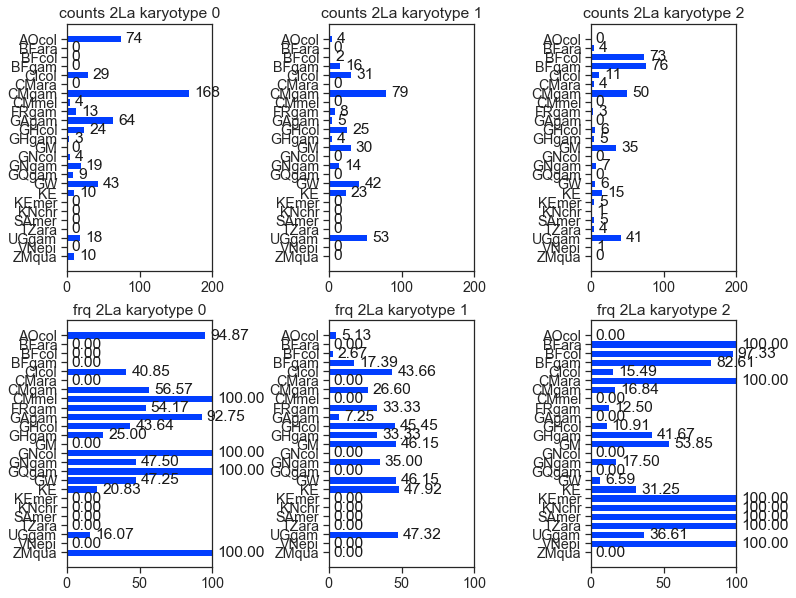

In [57]:
fig = plt.figure(figsize=(12,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=None)

pdf = PdfPages("%s/%s.inversion_karyotype_freq.pdf" % (outdir,outcode))
for ki in [0,1,2]:
    
    pie_labels = oc_popl
    # 2La counts per pop
    pie_counts = [len(np.where(np.logical_and(oc_samples["inv"].values==ki,oc_samples["population"].values==i))[0])  for i in oc_popl]
    ax = plt.subplot(2, 3, ki+1)
    plt.barh(width=pie_counts[::-1],y=pie_labels[::-1],color="b")
    annotate_barplot(ax=ax, labformat="{:.0f}")
    ax.set_xlim(0,200)
    ax.set_title("counts 2La karyotype %i" % ki)

    # 2La freqs per pop
    pie_counts = [100 * len(np.where(np.logical_and(oc_samples["inv"].values==ki, oc_samples["population"].values==i))[0])/len(np.where(np.logical_and(oc_samples["inv"].values>=0,oc_samples["population"].values==i))[0])  for i in oc_popl]
    ax = plt.subplot(2, 3, 3+ki+1)
    plt.barh(width=pie_counts[::-1],y=pie_labels[::-1],color="b")
    annotate_barplot(ax=ax, labformat="{:.2f}")
    ax.set_xlim(0,100)
    ax.set_title("frq 2La karyotype %i" % ki)

pdf.savefig(fig,bbox_inches='tight')
pdf.close()

We can now use this information to check our introgression hypotheses:

* **Introgression of 296S between BFcol <> arab**, which should be specific to the 2 (2La) karyotype, because arab and BFcol are fixed for 2La inversion.
* **Introgression of 296G between col <> gam**. Is it specific to the 0 (2L+a) karyotype? Does it happen on the 2 (2La) too?

* If there is introgression between 2La/2La *col* with 296S and 2La/2La *arab* *wt*, 

296S:

(((col_2_20,col_2_0),X),chri_2) chr


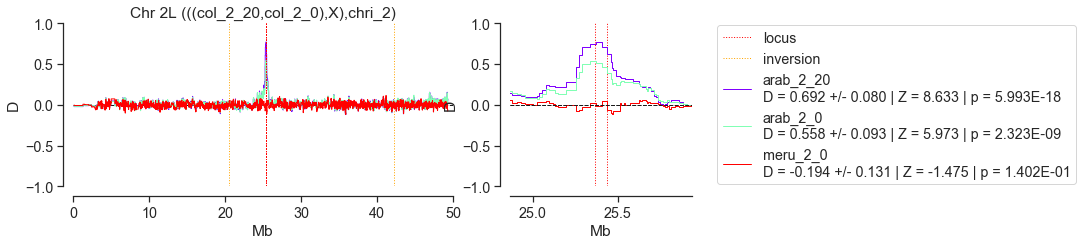

In [102]:
%%capture --no-stdout --no-display
loop_D_statistic3(
    name="296S_2back_donor_ara", 
    popA_list=["col_2_20"], 
    popB_list=["col_2_0"], 
    popC_list=["arab_2_20","arab_2_0","meru_2_0"], 
    popD_list=["chri_2"],
    popA_ac=oc_genalco_sps_seg_inv_gty, 
    popB_ac=oc_genalco_sps_seg_inv_gty, 
    popC_ac=oc_genalco_sps_seg_inv_gty, 
    popD_ac=oc_genalco_sps_seg_inv,
    pos=oc_genvars_seg["POS"][:],
    cycle="C"
)

(((arab_2_20,arab_2_0),X),chri_2) chr


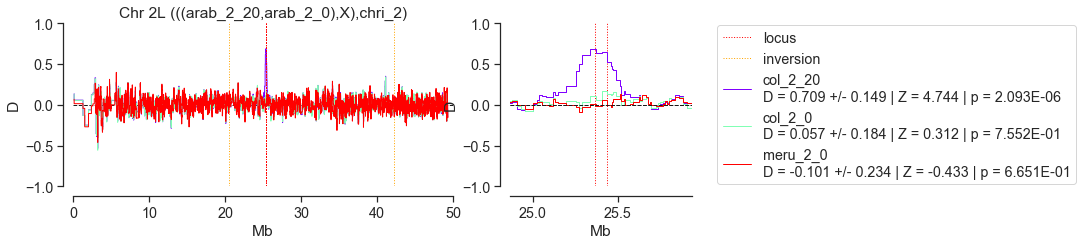

In [103]:
%%capture --no-stdout --no-display
loop_D_statistic3(
    name="296S_2back_donor_col", 
    popA_list=["arab_2_20"], 
    popB_list=["arab_2_0"], 
    popC_list=["col_2_20","col_2_0","meru_2_0"], 
    popD_list=["chri_2"],
    popA_ac=oc_genalco_sps_seg_inv_gty, 
    popB_ac=oc_genalco_sps_seg_inv_gty, 
    popC_ac=oc_genalco_sps_seg_inv_gty, 
    popD_ac=oc_genalco_sps_seg_inv,
    pos=oc_genvars_seg["POS"][:],
    cycle="C"
)

296G 2L+a/2L+a (0) background:

(((GHcol_0_2,GHcol_0_0),X),mela_0) chr


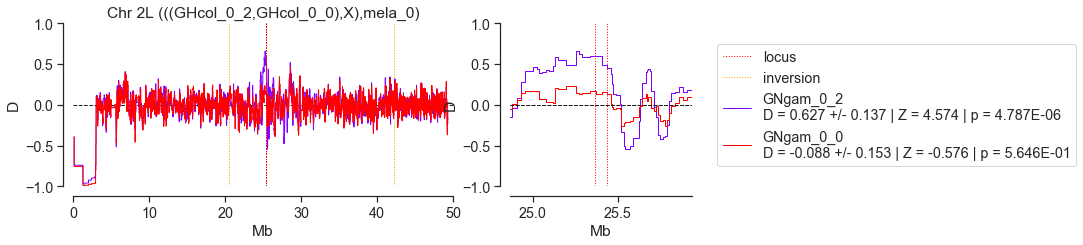

In [121]:
%%capture --no-stdout --no-display
loop_D_statistic3(
    name="296G_0back_donor_gam", 
    popA_list=["GHcol_0_2"], 
    popB_list=["GHcol_0_0"], 
    popC_list=["GNgam_0_2","GNgam_0_0"], 
    popD_list=["mela_0"],
    popA_ac=oc_genalco_pop_seg_inv_gty, 
    popB_ac=oc_genalco_pop_seg_inv_gty, 
    popC_ac=oc_genalco_pop_seg_inv_gty, 
    popD_ac=oc_genalco_sps_seg_inv,
    pos=oc_genvars_seg["POS"][:],
    cycle="C"
)

(((GNgam_0_2,GNgam_0_0),X),mela_0) chr


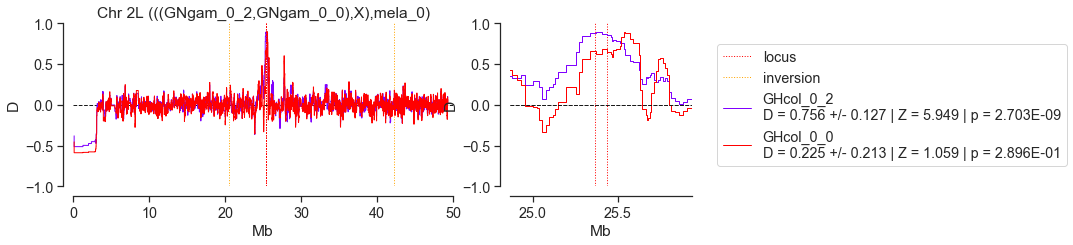

In [122]:
%%capture --no-stdout --no-display
loop_D_statistic3(
    name="296G_0back_donor_col", 
    popA_list=["GNgam_0_2"], 
    popB_list=["GNgam_0_0"], 
    popC_list=["GHcol_0_2","GHcol_0_0"], 
    popD_list=["mela_0"],
    popA_ac=oc_genalco_pop_seg_inv_gty, 
    popB_ac=oc_genalco_pop_seg_inv_gty, 
    popC_ac=oc_genalco_pop_seg_inv_gty, 
    popD_ac=oc_genalco_sps_seg_inv,
    pos=oc_genvars_seg["POS"][:],
    cycle="C"
)

(((gam_0_2,gam_0_0),X),mela_0) chr


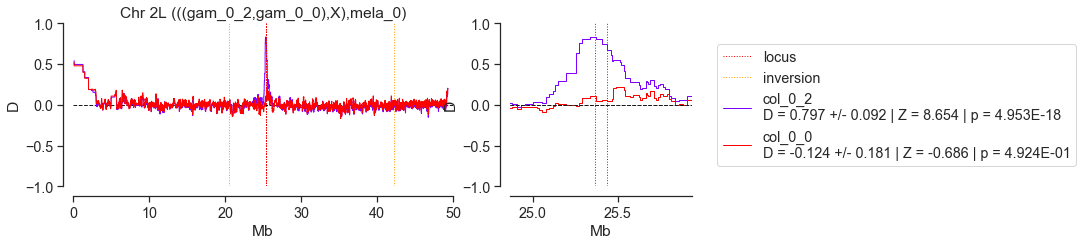

In [105]:
%%capture --no-stdout --no-display
loop_D_statistic3(
    name="296G_0back_donor_col", 
    popA_list=["gam_0_2"], 
    popB_list=["gam_0_0"], 
    popC_list=["col_0_2","col_0_0"], 
    popD_list=["mela_0"],
    popA_ac=oc_genalco_sps_seg_inv_gty, 
    popB_ac=oc_genalco_sps_seg_inv_gty, 
    popC_ac=oc_genalco_sps_seg_inv_gty, 
    popD_ac=oc_genalco_sps_seg_inv,
    pos=oc_genvars_seg["POS"][:],
    cycle="C"
)

### A296S between BFcol_2 <> arab

#### Inverted background.

First, we look at **introgression of the 296S cluster between BFcol_2 and *arabiensis***, using inverted and non-inverted gambiae and coluzzii as control B. 

* A is BFcol_2
* B are contrasts without 296S but with 2La inversions: GHgam, CMgam, UGgam, CIcol (2) ; I exclude hybrids (GW...)
* C are putative donors/acceptors with 2La inversions: arab, meru
* D are inverted outgroups (epir, chri)

Result: **BFcol Rdl has an introgression peak with arab** when compared against an inverted background. 

In [ ]:
oc_genalco_sps_seg_inv_gty

In [ ]:
%%capture --no-stdout --no-display
loop_D_statistic3(
    name="araBFcol_back2_inv_B2", 
    popA_list=["BFcol_2"], 
    popB_list=["GHgam_2","CMgam_2","UGgam_2","CIcol_2"], 
    popC_list=["arab_2","meru_2"], 
    popD_list=["epir_2","chri_2"],
    popA_ac=oc_genalco_pop_seg_inv, 
    popB_ac=oc_genalco_pop_seg_inv, 
    popC_ac=oc_genalco_sps_seg_inv, 
    popD_ac=oc_genalco_sps_seg_inv,
    pos=oc_genvars_seg["POS"][:],
    cycle="C"
)

#### A296S between BFcol_2 <> arab populations

Repeat analysis above to see if there is differential introgression between BFcol and any of the *arabiensis* populations. 

Result: all arab populations them have clear introgression signals in *Rdl*.

In [ ]:
%%capture --no-stdout --no-display
loop_D_statistic3(
    name="araBFcol_back2_inv_B2_arapop", 
    popA_list=["BFcol_2"], 
    popB_list=["GHgam_2","CMgam_2","UGgam_2","CIcol_2"], 
    popC_list=["BFara_2","CMara_2","TZara_2","KEmer_2","SAmer_2"], 
    popD_list=["epir_2"],
    popA_ac=oc_genalco_pop_seg_inv, 
    popB_ac=oc_genalco_pop_seg_inv, 
    popC_ac=oc_genalco_pop_seg_inv, 
    popD_ac=oc_genalco_sps_seg_inv,
    pos=oc_genvars_seg["POS"][:],
    cycle="C"
)

### 296G between gam<>col

Another possible case of admixture is suggested by the co-occurrence of col and gam in the main component of the 296G haplotype cluster. 

#### 296G introgression in the non-inverted background 

First, let's see if this is the case in the non-inverted background (0 or 2L+a haplotypes). This is the most abundant background for 296G haplotypes, so it could be the ancestral one.

* A are non-inverted gam pops in the 296G cluster (GAgam_0,GHgam_0,GNgam_0,CMgam_0,GQgam_0)
* B is a gam not in cluster and non-inverted (UGgam_0)
* C are various cols, some in cluster ("AOcol_0","CIcol_0","GHcol_0") and some not ("GNcol_0"). We expect introgression with cols in cluster, and no introgression with the wt-only col pop.
* D are non-inverted outgroups: mela and quad

This demonstrates that there was **introgression of 296G between gambiae and coluzzi, which happened on a non-inverted background**. This occurred somewhere in West Africa, as signal is stronger in WA populations but weaker in CMgam.

In [ ]:
%%capture --no-stdout --no-display
loop_D_statistic3(
    name="colgam_clu296G_back0_ABgam_Ccol",
    popA_list=["CMgam_0","GAgam_0","GHgam_0","GNgam_0","GQgam_0"], 
    popB_list=["UGgam_0"],
    popC_list=["AOcol_0","CIcol_0","GHcol_0","GNcol_0"], 
    popD_list=["quad_0","mela_0"],
    popA_ac=oc_genalco_pop_seg_inv, 
    popB_ac=oc_genalco_pop_seg_inv, 
    popC_ac=oc_genalco_pop_seg_inv, 
    popD_ac=oc_genalco_sps_seg_inv,
    pos=oc_genvars_seg["POS"][:],
    cycle="C"
)

#### Introgression in the inverted background (`2`)

Now, let's see if the minority 296G-2La haplotype also has signals of introgression:

* A are inverted gams in 296G cluster ("GHgam_2","GNgam_2","CMgam_2")
* B is a gam not in cluster and inverted (UGgam_2)
* C are various cols, some in cluster ("CIcol_2","GHcol_2") and some not ("BFcol_2")
* D are non-inverted outgroups: meru, epir, chri; arab is not good because of independent introgression with BFcol_2

This demonstrates that there was **no introgression of 296G between gambiae and coluzzi in the inverted background**.

In [ ]:
%%capture --no-stdout --no-display
loop_D_statistic3(
    name="colgam_clu296G_back2_ABgam_Ccol",
    popA_list=["BFgam_2","CMgam_2","GHgam_2","GNgam_2"],
    popB_list=["UGgam_2"],
    popC_list=["CIcol_2","GHcol_2","BFcol_2"], 
    popD_list=["meru_2","epir_2","chri_2","arab_2"],
    popA_ac=oc_genalco_pop_seg_inv, 
    popB_ac=oc_genalco_pop_seg_inv, 
    popC_ac=oc_genalco_pop_seg_inv, 
    popD_ac=oc_genalco_sps_seg_inv,
    pos=oc_genvars_seg["POS"][:],
    cycle="C"
)

#### Introgression of 296G between karyotypes (`0` and `2`)

Are there signals of introgression between the 2La and 2L+a haplotypes in populations that also have the 296G allele?

* A are non-inverted gam pops in the 296G cluster (GAgam_0,GHgam_0,GNgam_0,CMgam_0,GQgam_0)
* B is non-inverted gam not in cluster (UGgam_0)
* C are inverted gamcols with 296G cluster ("GHgam_2","GNgam_2","CMgam_2")
* D are non-inverted OR inverted outgroups (analysed separately)

This analysis is problematic because `(((A,B),C),D)` is not valid along the entire chromosome, but in the Rdl locus specifically it does hint at 0<>2 introgression specific to 296G-carrying samples.

In [ ]:
%%capture --no-stdout --no-display
loop_D_statistic3(
    name="colgam_clu296G_interkaryotype_2back",
    popA_list=["CMgam_0","GAgam_0","GHgam_0","GNgam_0","GQgam_0","AOcol_0","CIcol_0","GHcol_0"], 
    popB_list=["UGgam_0"],
    popC_list=["BFgam_2","CMgam_2","GHgam_2","GNgam_2"], 
    popD_list=["meru_2"],
    popA_ac=oc_genalco_pop_seg_inv, 
    popB_ac=oc_genalco_pop_seg_inv, 
    popC_ac=oc_genalco_pop_seg_inv, 
    popD_ac=oc_genalco_sps_seg_inv,
    pos=oc_genvars_seg["POS"][:],
    cycle="C"
)

In [ ]:
%%capture --no-stdout --no-display
loop_D_statistic3(
    name="colgam_clu296G_interkaryotype_0back",
    popA_list=["CMgam_0","GAgam_0","GHgam_0","GNgam_0","GQgam_0","AOcol_0","CIcol_0","GHcol_0"], 
    popB_list=["UGgam_0"],
    popC_list=["BFgam_2","CMgam_2","GHgam_2","GNgam_2"], 
    popD_list=["quad_0","mela_0"],
    popA_ac=oc_genalco_pop_seg_inv, 
    popB_ac=oc_genalco_pop_seg_inv, 
    popC_ac=oc_genalco_pop_seg_inv, 
    popD_ac=oc_genalco_sps_seg_inv,
    pos=oc_genvars_seg["POS"][:],
    cycle="C"
)

#### Plot transcripts in region of interest

Finally, plot the coordinates of transcripts in the region of interest, so that you can create nice-looking plots:

In [ ]:
pdf = PdfPages("%s/%s.genes.pdf" % (outdir,outcode))
# plot transcripts
fig = plt.figure(figsize=(15,2))
ax4 = plt.subplot(1, 4, 3)
sns.despine(ax=ax4,offset=10)
locus_genel = plot_transcripts(
    geneset=geneset,chrom=chrom,
    start=loc_start-5e5,stop=loc_end+5e5,
    height=0.1,label_transcripts=False,ax=ax4,label_axis=False,
    color="slategray")

pdf.savefig(fig,bbox_inches='tight')
pdf.close()

## Differentiation

Calculate Hudson's $F_{ST}$ along the entire 2L chromosomal arm, to see if there is a drop in differentiation between non-concordant karyotypes at the center of the 2La inversion.

First, a loop function.

In [ ]:
def loop_Fst(name, popA_list, popC_list, 
             popA_ac, popC_ac,
             pos,cycle = "C", block_len_snp=block_len_snp, step_len_snp=step_len_snp,
             color=["blue","darkorange","turquoise","crimson","magenta","limegreen",
                    "forestgreen","slategray","orchid","darkblue"]):
    
    windows_pos = allel.moving_statistic(pos, statistic=lambda v: v[0], size=block_len_snp,step=step_len_snp)

    # calculate pvalues and focus in this region: duplicated region proper
    is_locus = np.logical_and(pos > loc_start,pos < loc_end) # gene region
    is_inv   = np.logical_and(pos > inv_start,pos < inv_end) # inversion region
    
    # loop
    pdf = PdfPages("%s/%s.Fst_%s.pdf" % (outdir,outcode,name))
        
    colors = cm.rainbow(np.linspace(0, 1, len(popC_list)))

    for an,popA in enumerate(popA_list):

        fig = plt.figure(figsize=(15,3))

        # whole chromosome: frame
        ax1 = plt.subplot(1, 2, 1)
        sns.despine(ax=ax1,offset=10)
        ax1.set_title("Chr %s Fst %s~X" % (chrom,popA))
        ax1.set_xlim(0,50)
        ax1.set_ylim(0,1)
        ax1.set_xlabel("Mb")
        ax1.set_ylabel("Fst")
        plt.axhline(0, color='k',linestyle="--",label="")
        plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
        plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
        plt.axvline(inv_start/1e6, color='orange',linestyle=":",label="inversion")
        plt.axvline(inv_end/1e6, color='orange',linestyle=":",label="")

        ax2 = plt.subplot(1, 4, 3)
        sns.despine(ax=ax2,offset=10)
        ax2.set_xlim(loc_start/1e6-0.5,loc_end/1e6+0.5)
        ax2.set_ylim(0,1)
        ax2.set_xlabel("Mb")
        ax2.set_ylabel("Fst")
        plt.axhline(0, color='k',linestyle="--",label="")
        plt.axvline(loc_start/1e6, color='red',linestyle=":",label="locus")
        plt.axvline(loc_end/1e6, color='red',linestyle=":",label="")
        plt.axvline(inv_start/1e6, color='orange',linestyle=":",label="inversion")
        plt.axvline(inv_end/1e6, color='orange',linestyle=":",label="")

        for cn,popC in enumerate(popC_list):

            if popA != popC:

                # block-wise patterson D (normalised)
                admix_pd_n_win = allel.moving_hudson_fst( 
                    ac1=popA_ac[popA][:,0:2],
                    ac2=popC_ac[popC][:,0:2],
                    size=block_len_snp,step=step_len_snp)

                # whole chromosome: plot
                plt.subplot(1, 2, 1)
                plt.step(windows_pos/1e6, admix_pd_n_win, color=colors[cn])

                # estimated D in locus with pval
                admix_pd_av_indup = allel.average_hudson_fst(
                    ac1=popA_ac[popA][:,0:2][is_locus],
                    ac2=popC_ac[popC][:,0:2][is_locus],
                    blen=100)
                # zoomed region: plot
                plt.subplot(1, 4, 3)
                plt.step(windows_pos/1e6, admix_pd_n_win, color=colors[cn], 
                         label="%s\nFst = %.3f +/- %.3f" % 
                             (popC,admix_pd_av_indup[0],admix_pd_av_indup[1]))

        plt.axhline(0, color='k',linestyle="--",label="")
        ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

        # save pdf
        pdf.savefig(fig,bbox_inches='tight')

    pdf.close()

Plot differentiation between specimens grouped by species and karyotype:

In [ ]:
%%capture --no-stdout --no-display
loop_Fst(
    name="colgaminv",
    popA_list=["gam_0","gam_2"],
    popC_list=["gam_0","col_0","gam_2","col_2"],
    popA_ac=oc_genalco_sps_seg_inv, 
    popC_ac=oc_genalco_sps_seg_inv, 
    pos=oc_genvars_seg["POS"][:],
    cycle="C"
)